In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn

torch.manual_seed(27)

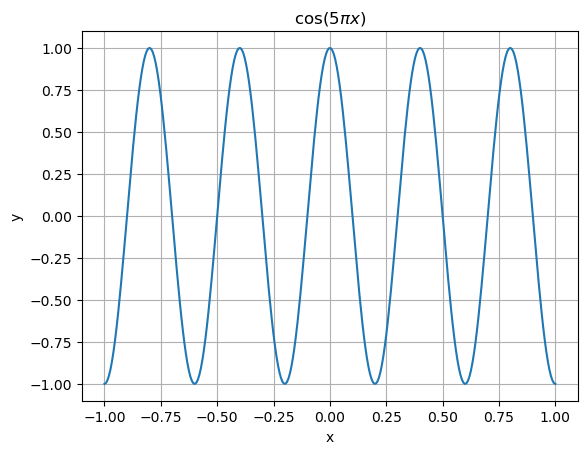

In [2]:
def cosineFunction(x):
  return (np.cos(5 * np.pi * x))

x = np.linspace(-1, 1, 300).reshape(-1, 1)
y = cosineFunction(x)
func1_x, func1_y = torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
plt.plot(func1_x, func1_y)
plt.title(r'${\cos(5 \pi x)}$')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()

In [3]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.layer_1 = nn.Linear(1, 5)
        self.layer_2 = nn.Linear(5, 15)
        self.layer_3 = nn.Linear(15, 15)
        self.layer_4 = nn.Linear(15, 15)
        self.layer_5 = nn.Linear(15, 15)
        self.layer_6 = nn.Linear(15, 15)
        self.layer_7 = nn.Linear(15, 15)
        self.layer_8 = nn.Linear(15, 5)
        self.layer_9 = nn.Linear(5, 1)

    def forward(self, inputData):
        layerOut1 = nn.functional.relu(self.layer_1(inputData))
        layerOut2 = nn.functional.relu(self.layer_2(layerOut1))
        layerOut3 = nn.functional.relu(self.layer_3(layerOut2))
        layerOut4 = nn.functional.relu(self.layer_4(layerOut3))
        layerOut5 = nn.functional.relu(self.layer_5(layerOut4))
        layerOut6 = nn.functional.relu(self.layer_6(layerOut5))
        layerOut7 = nn.functional.relu(self.layer_7(layerOut6))
        layerOut8 = nn.functional.relu(self.layer_8(layerOut7))
        layerOut9 = self.layer_9(layerOut8)
        return layerOut9

In [4]:
model = Model()
total_params = sum(p.numel() for p in model.parameters())
print('Total params - ', total_params)

Total params -  1386


In [5]:
def train(model, inputData, groundTruth):
    losses = []
    epoch = 0
    totalEpochs = 20000
    acceptableLoss = 0.0001
    acceptableGradNorm = 0.001
    optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)
    isConverged = epoch >= totalEpochs

    print(f'Training for {totalEpochs} epochs until Loss goes below {acceptableGradNorm}')

    while not isConverged:
        model.train()
        predictedOutput = model(inputData)  
        loss = nn.MSELoss()(predictedOutput, groundTruth)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step() 
        currentLoss = loss.detach().numpy()
        losses.append(currentLoss)

        gradSum = 0.0
        for p in model.parameters():
            grad =  (p.grad.cpu().data.numpy()**2).sum() if (p.grad is not None) else 0.0
            gradSum += grad
        gradNorm = gradSum ** 0.5

        if epoch % 1000 == 0:
            print(f'epoch: {epoch} currentLoss: {currentLoss} gradientNorm: {gradNorm}')

        epoch += 1
        isConverged = epoch >= totalEpochs or gradNorm < acceptableGradNorm

    minimal_ratio, loss_val = calculate_hessian(model, inputData, groundTruth)
    print(f"epoch: {epoch} Minimal Ratio: {minimal_ratio}  Loss: {loss_val}\n")
    return minimal_ratio, loss_val

In [6]:
def calculate_hessian(model, x, y):
    criterion = nn.MSELoss()
    total_params = sum(p.numel() for p in model.parameters())

    predictions = model(x)
    loss = criterion(predictions, y)

    Jacob = torch.autograd.grad(loss, model.parameters(), create_graph=True)
    Jacob_flat = torch.cat([e.flatten() for e in Jacob])

    H = torch.zeros((total_params, total_params))

    for i in range(total_params):
        result = torch.autograd.grad(Jacob_flat[i], model.parameters(), retain_graph=True)
        H[i] = torch.cat([r.flatten() for r in result])

    H_eigenvalues = torch.linalg.eig(H).eigenvalues.real
    positive_count = (H_eigenvalues > 0).sum().item()
    minimal_ratio = positive_count / total_params

    return minimal_ratio, loss.item()

In [7]:
loss_arr = []
min_ratio_arr = []
for index in range(100):
    print("Training model ", index)
    model = Model()
    optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay = 1e-5)

    min_ratio, loss_value = train(model, func1_x, func1_x)
    loss_arr.append(loss_value)
    min_ratio_arr.append(min_ratio)

Training model  0
Training for 20000 epochs until Loss goes below 0.001
epoch: 0 currentLoss: 0.47795867919921875 gradientNorm: 0.8608432700845996
epoch: 1000 currentLoss: 0.018095476552844048 gradientNorm: 0.07189023128696759
epoch: 2000 currentLoss: 0.00034788966877385974 gradientNorm: 0.006115735514192596
epoch: 2951 Minimal Ratio: 0.25757575757575757  Loss: 3.583202123991214e-05

Training model  1
Training for 20000 epochs until Loss goes below 0.001
epoch: 0 currentLoss: 0.4282243847846985 gradientNorm: 0.6761848884897569
epoch: 1000 currentLoss: 0.03236721456050873 gradientNorm: 0.20851475409815107
epoch: 1877 Minimal Ratio: 0.2784992784992785  Loss: 9.17208944883896e-06

Training model  2
Training for 20000 epochs until Loss goes below 0.001
epoch: 0 currentLoss: 0.3592028319835663 gradientNorm: 0.3792414633529094
epoch: 1000 currentLoss: 0.14070381224155426 gradientNorm: 0.4215136750342594
epoch: 2000 currentLoss: 0.09265583753585815 gradientNorm: 0.33670060833703164
epoch: 300

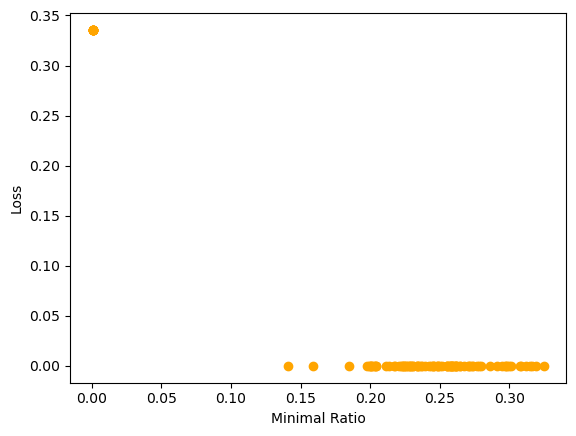

In [8]:
plt.scatter(min_ratio_arr,loss_arr, color = "orange")
plt.xlabel("Minimal Ratio")
plt.ylabel("Loss")
plt.show()